<a href="https://colab.research.google.com/github/sirajummprince/datahandling/blob/master/Airports.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import os.path as osp
from typing import Callable, List, Optional

!pip install torch
!pip install torch_geometric
!pip install networkx

import torch

from torch_geometric.data import Data, InMemoryDataset, download_url
from torch_geometric.utils import coalesce
from torch_geometric.datasets import Airports

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

from google.colab import drive

drive.mount('/content/gdrive')

path = 'gdrive/MyDrive/Colab/Airports'

Mounted at /content/gdrive


In [4]:
class Airports(InMemoryDataset):
    edge_url = ('https://github.com/leoribeiro/struc2vec/'
                'raw/master/graph/{}-airports.edgelist')
    label_url = ('https://github.com/leoribeiro/struc2vec/'
                 'raw/master/graph/labels-{}-airports.txt')

    def __init__(
        self,
        root: str,
        name: str,
        transform: Optional[Callable] = None,
        pre_transform: Optional[Callable] = None,
        force_reload: bool = False,
    ) -> None:
        self.name = name.lower()
        assert self.name in ['usa', 'brazil', 'europe']
        super().__init__(root, transform, pre_transform,
                         force_reload=force_reload)
        self.load(self.processed_paths[0])

    @property
    def raw_dir(self) -> str:
        return osp.join(self.root, self.name, 'raw')

    @property
    def processed_dir(self) -> str:
        return osp.join(self.root, self.name, 'processed')

    @property
    def raw_file_names(self) -> List[str]:
        return [
            f'{self.name}-airports.edgelist',
            f'labels-{self.name}-airports.txt',
        ]

    @property
    def processed_file_names(self) -> str:
        return 'data.pt'

    def download(self) -> None:
        download_url(self.edge_url.format(self.name), self.raw_dir)
        download_url(self.label_url.format(self.name), self.raw_dir)

    def process(self) -> None:
        index_map, ys = {}, []
        with open(self.raw_paths[1]) as f:
            rows = f.read().split('\n')[1:-1]
            for i, row in enumerate(rows):
                idx, label = row.split()
                index_map[int(idx)] = i
                ys.append(int(label))
        y = torch.tensor(ys, dtype=torch.long)
        x = torch.eye(y.size(0))

        edge_indices = []
        with open(self.raw_paths[0]) as f:
            rows = f.read().split('\n')[:-1]
            for row in rows:
                src, dst = row.split()
                edge_indices.append([index_map[int(src)], index_map[int(dst)]])
        edge_index = torch.tensor(edge_indices).t().contiguous()
        edge_index = coalesce(edge_index, num_nodes=y.size(0))

        data = Data(x=x, edge_index=edge_index, y=y)
        data = data if self.pre_transform is None else self.pre_transform(data)
        self.save([data], self.processed_paths[0])

    def __repr__(self) -> str:
        return f'{self.name.capitalize()}Airports()'

In [5]:
root_dir = './datasets/'

dataset_name_usa = 'USA'
dataset_name_brazil = 'Brazil'
dataset_name_europe = 'europe'

dataset_usa = Airports(root = root_dir, name = dataset_name_usa)
dataset_brazil = Airports(root = root_dir, name = dataset_name_brazil)
dataset_europe = Airports(root = root_dir, name = dataset_name_europe)

Processing...
Done!
Processing...
Done!
Processing...
Done!


In [14]:
import networkx as nx
from networkx.algorithms import community
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.sparse as sp
from torch_geometric.utils import to_networkx

In [26]:
dataset_usa[0]

Data(x=[1190, 1190], edge_index=[2, 13599], y=[1190])

In [27]:
dataset_brazil[0]

Data(x=[131, 131], edge_index=[2, 1074], y=[131])

In [28]:
dataset_europe[0]

Data(x=[399, 399], edge_index=[2, 5995], y=[399])

In [31]:
data_usa = dataset_usa[0]
print(f'Dataset_USA has isolated node: {data_usa.has_isolated_nodes}')
print(f'Dataset_USA has self loops: {data_usa.has_self_loops}')
print(f'Dataset_USA is undirected: {data_usa.is_undirected}')

Dataset_USA has isolated node: <bound method BaseData.has_isolated_nodes of Data(x=[1190, 1190], edge_index=[2, 13599], y=[1190])>
Dataset_USA has self loops: <bound method BaseData.has_self_loops of Data(x=[1190, 1190], edge_index=[2, 13599], y=[1190])>
Dataset_USA is undirected: <bound method BaseData.is_undirected of Data(x=[1190, 1190], edge_index=[2, 13599], y=[1190])>


In [33]:
edge_index = data_usa.edge_index.numpy()
print(edge_index.shape)
edge_example = edge_index[:, np.where(edge_index[0] == 30)[0]]
edge_example

(2, 13599)


array([[  30,   30,   30,   30,   30,   30,   30,   30,   30,   30,   30,
          30],
       [  86,  160,  172,  326,  346,  434,  439,  446,  741, 1054, 1086,
        1156]])

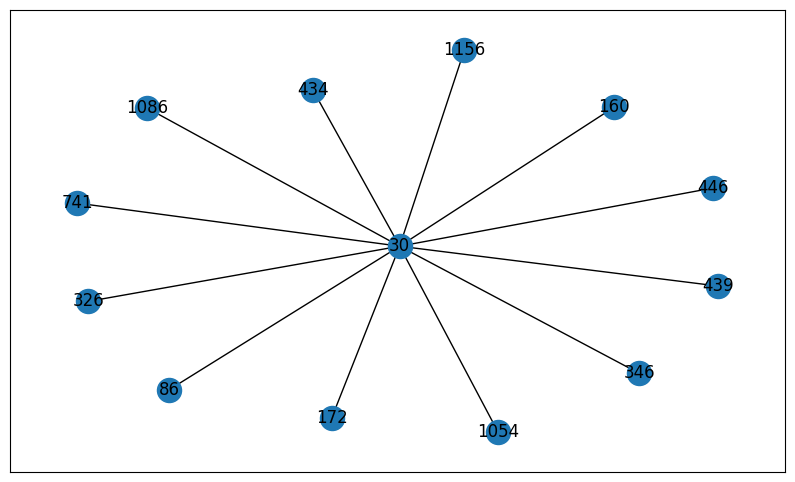

In [34]:
node_example = np.unique(edge_example.flatten())
plt.figure(figsize = (10, 6))
G = nx.Graph()
G.add_nodes_from(node_example)
G.add_edges_from(list(zip(edge_example[0], edge_example[1])))
nx.draw_networkx(G, with_labels = True)

In [36]:
print(f'Average node degree: {data_usa.num_edges / data_usa.num_nodes: .2f}')

Average node degree:  11.43


,count,mean,std,min,25%,50%,75%,max
0,1190.0,22.86,40.47,1.0,2.0,6.0,20.75,238.0


1190
27198


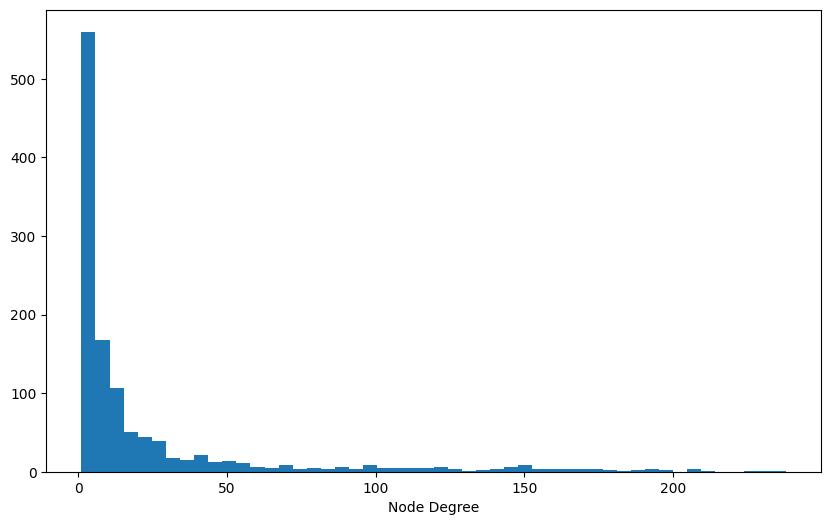

In [38]:
G = to_networkx(data_usa, to_undirected = True)
degrees = [val for (node, val) in G.degree()]

display(pd.DataFrame(pd.Series(degrees).describe()).transpose().round(2))
print(len(degrees))
print(sum(degrees))

plt.figure(figsize = (10, 6))
plt.hist(degrees, bins = 50)
plt.xlabel('Node Degree')
plt.show()

In [39]:
data_brazil = dataset_brazil[0]
print(f'Dataset_Brazil has isolated node: {data_brazil.has_isolated_nodes}')
print(f'Dataset_Brazil has self loops: {data_brazil.has_self_loops}')
print(f'Dataset_Brazil is undirected: {data_brazil.is_undirected}')

Dataset_Brazil has isolated node: <bound method BaseData.has_isolated_nodes of Data(x=[131, 131], edge_index=[2, 1074], y=[131])>
Dataset_Brazil has self loops: <bound method BaseData.has_self_loops of Data(x=[131, 131], edge_index=[2, 1074], y=[131])>
Dataset_Brazil is undirected: <bound method BaseData.is_undirected of Data(x=[131, 131], edge_index=[2, 1074], y=[131])>


In [40]:
edge_index = data_brazil.edge_index.numpy()
print(edge_index.shape)
edge_example = edge_index[:, np.where(edge_index[0] == 30)[0]]
edge_example

(2, 1074)


array([[30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30],
       [ 1,  4,  5, 13, 15, 27, 30, 31, 51, 53, 67, 69, 70, 94]])

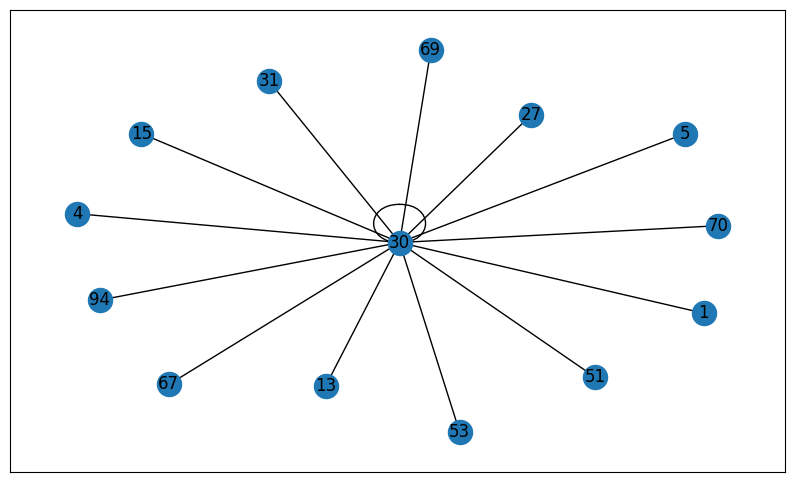

In [41]:
node_example = np.unique(edge_example.flatten())
plt.figure(figsize = (10, 6))
G = nx.Graph()
G.add_nodes_from(node_example)
G.add_edges_from(list(zip(edge_example[0], edge_example[1])))
nx.draw_networkx(G, with_labels = True)

In [42]:
print(f'Average node degree: {data_brazil.num_edges / data_brazil.num_nodes: .2f}')

Average node degree:  8.20


,count,mean,std,min,25%,50%,75%,max
0,131.0,16.4,17.34,1.0,3.5,10.0,23.5,81.0


131
2148


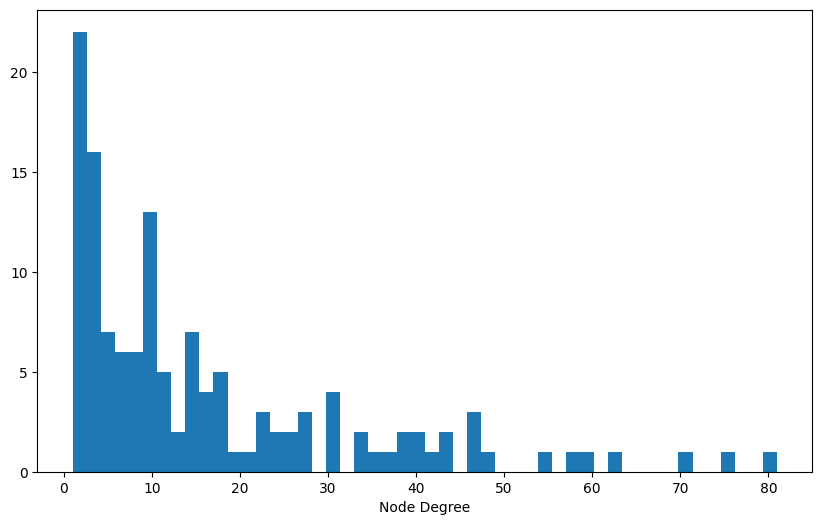

In [50]:
G = to_networkx(data_brazil, to_undirected = True)
degrees = [val for (node, val) in G.degree()]

display(pd.DataFrame(pd.Series(degrees).describe()).transpose().round(2))
print(len(degrees))
print(sum(degrees))

plt.figure(figsize = (10, 6))
plt.hist(degrees, bins = 50)
plt.xlabel('Node Degree')
plt.show()

In [44]:
data_eu = dataset_europe[0]
print(f'Dataset_Europe has isolated node: {data_eu.has_isolated_nodes}')
print(f'Dataset_Europe has self loops: {data_eu.has_self_loops}')
print(f'Dataset_Europe is undirected: {data_eu.is_undirected}')

Dataset_Europe has isolated node: <bound method BaseData.has_isolated_nodes of Data(x=[399, 399], edge_index=[2, 5995], y=[399])>
Dataset_Europe has self loops: <bound method BaseData.has_self_loops of Data(x=[399, 399], edge_index=[2, 5995], y=[399])>
Dataset_Europe is undirected: <bound method BaseData.is_undirected of Data(x=[399, 399], edge_index=[2, 5995], y=[399])>


In [52]:
edge_index = data_eu.edge_index.numpy()
print(edge_index.shape)
edge_example = edge_index[:, np.where(edge_index[0] == 30)[0]]
edge_example

(2, 5995)


array([[30, 30, 30, 30, 30, 30, 30, 30],
       [14, 15, 16, 17, 18, 20, 26, 28]])

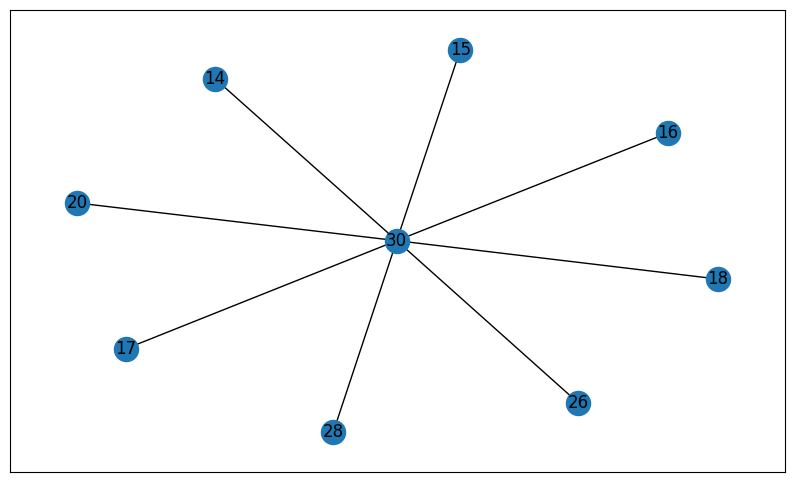

In [53]:
node_example = np.unique(edge_example.flatten())
plt.figure(figsize = (10, 6))
G = nx.Graph()
G.add_nodes_from(node_example)
G.add_edges_from(list(zip(edge_example[0], edge_example[1])))
nx.draw_networkx(G, with_labels = True)

In [47]:
print(f'Average node degree: {data_eu.num_edges / data_eu.num_nodes: .2f}')

Average node degree:  15.03


,count,mean,std,min,25%,50%,75%,max
0,399.0,30.05,34.69,1.0,5.0,15.0,43.0,202.0


399
11990


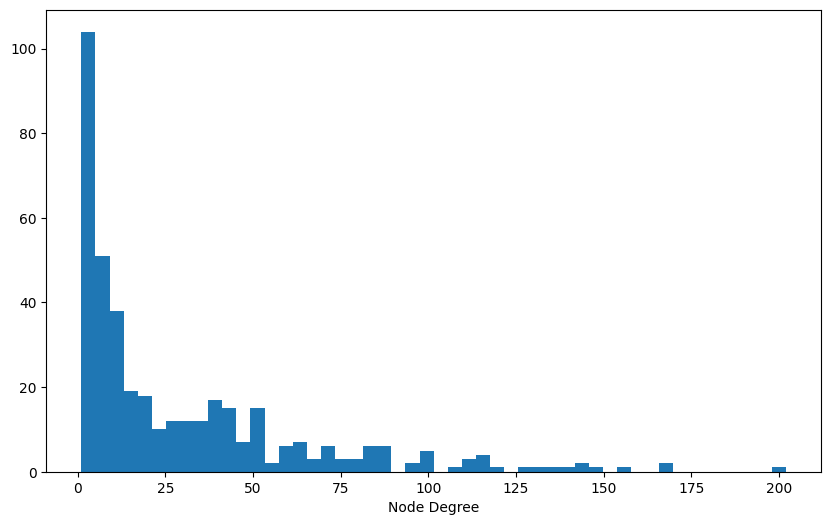

In [49]:
G = to_networkx(data_eu, to_undirected = True)
degrees = [val for (node, val) in G.degree()]

display(pd.DataFrame(pd.Series(degrees).describe()).transpose().round(2))
print(len(degrees))
print(sum(degrees))

plt.figure(figsize = (10, 6))
plt.hist(degrees, bins = 50)
plt.xlabel('Node Degree')
plt.show()